In [3]:
!nvidia-smi
import torch
print("CUDA available:", torch.cuda.is_available())


Sat Aug 30 09:49:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip -q install -U transformers datasets accelerate evaluate scikit-learn matplotlib pandas


In [5]:
from google.colab import drive
import pathlib, os

# Mount your Drive
drive.mount('/content/drive')

# Create a project folder in Drive
PROJ = '/content/drive/MyDrive/mental_bert_project'
pathlib.Path(PROJ).mkdir(parents=True, exist_ok=True)
print("Project folder:", PROJ)


Mounted at /content/drive
Project folder: /content/drive/MyDrive/mental_bert_project


In [6]:
from google.colab import files
import shutil

uploaded = files.upload()  # select mentalhealth.csv from your computer

for fn in uploaded.keys():
    dest = os.path.join(PROJ, fn)
    shutil.move(fn, dest)
    print("Saved to:", dest)


Saving mentalhealth.csv to mentalhealth.csv
Saved to: /content/drive/MyDrive/mental_bert_project/mentalhealth.csv


In [7]:
import pandas as pd

DATA_CSV = os.path.join(PROJ, 'mentalhealth.csv')
df = pd.read_csv(DATA_CSV)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (53043, 3)
Columns: ['Unnamed: 0', 'statement', 'status']


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
from sklearn.model_selection import train_test_split

# Keep only the columns we need
df = df[['statement', 'status']].dropna().drop_duplicates()

# Rename for convenience
df = df.rename(columns={'statement':'text', 'status':'label_raw'})

# Encode labels (string → numeric id)
label_names = sorted(df['label_raw'].unique().tolist())
label2id = {lab:i for i,lab in enumerate(label_names)}
id2label = {i:lab for lab,i in label2id.items()}

df['label'] = df['label_raw'].map(label2id)

print("Classes:", id2label)

# Stratified 80/20 split
train_df, test_df = train_test_split(
    df[['text','label']],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

# Save splits into Drive
train_path = os.path.join(PROJ, 'train.csv')
test_path  = os.path.join(PROJ, 'test.csv')
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved:", train_path, test_path)



Classes: {0: 'Anxiety', 1: 'Bipolar', 2: 'Depression', 3: 'Normal', 4: 'Personality disorder', 5: 'Stress', 6: 'Suicidal'}
Train shape: (40874, 2) Test shape: (10219, 2)
Saved: /content/drive/MyDrive/mental_bert_project/train.csv /content/drive/MyDrive/mental_bert_project/test.csv


In [9]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer

# Load train/test splits
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Choose model (BERT or DistilBERT for faster training)
MODEL_NAME = "distilbert-base-uncased"   # you can change to "bert-base-uncased" (slower, heavier)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Train:", train_df.shape, "Test:", test_df.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train: (40874, 2) Test: (10219, 2)


In [10]:
from datasets import Dataset

# Convert DataFrame → HuggingFace Dataset
train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenizer
train_ds = train_ds.map(tokenize, batched=True, batch_size=1024)
test_ds  = test_ds.map(tokenize,  batched=True, batch_size=1024)

# Prepare dataset for PyTorch
train_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
test_ds.set_format(type="torch",  columns=["input_ids","attention_mask","label"])

print(train_ds)
print(test_ds)


Map:   0%|          | 0/40874 [00:00<?, ? examples/s]

Map:   0%|          | 0/10219 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 40874
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 10219
})


In [11]:
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification

num_labels = len(set(train_df['label']))
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to("cuda")

# ---- Class weights to handle imbalance ----
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

print("Class weights:", class_weights)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([2.0149, 2.9181, 0.4836, 0.4550, 8.1552, 3.1786, 0.6857],
       device='cuda:0')


In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch import nn
import numpy as np
import evaluate
from sklearn.utils.class_weight import compute_class_weight

# Reload tokenizer & model as BERT-base
MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
).to("cuda")

# ---- Class weights for imbalance ----
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
print("Class weights:", class_weights)

# Accuracy metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    return {"accuracy": acc["accuracy"]}

# Custom Trainer to apply weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir=os.path.join(PROJ, "results"),
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir=os.path.join(PROJ, "logs"),
    logging_steps=100,
    save_total_limit=2
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([2.0149, 2.9181, 0.4836, 0.4550, 8.1552, 3.1786, 0.6857],
       device='cuda:0')


/tmp/ipython-input-2050645297.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [19]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = loss_fn(logits, labels)

        if return_outputs:
            return (loss, outputs)
        return loss



In [25]:
from transformers import TrainerCallback

class LogCallback(TrainerCallback):
    def __init__(self):
        self.history = {"train_loss": [], "eval_loss": [], "eval_accuracy": []}

    def on_epoch_end(self, args, state, control, **kwargs):
        logs = state.log_history[-1] if state.log_history else {}
        if "loss" in logs:
            self.history["train_loss"].append(logs["loss"])
        if "eval_loss" in logs:
            self.history["eval_loss"].append(logs["eval_loss"])
        if "eval_accuracy" in logs:
            self.history["eval_accuracy"].append(logs["eval_accuracy"])



In [27]:
training_args = TrainingArguments(
    output_dir=os.path.join(PROJ, "results"),
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir=os.path.join(PROJ, "logs"),
    logging_steps=100,
    save_total_limit=2,
    report_to="none"   # ✅ disables wandb & other integrations
)



In [28]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# attach logging callback
log_callback = LogCallback()
trainer.add_callback(log_callback)

train_result = trainer.train()
trainer.save_model(os.path.join(PROJ, "bert_model"))


/tmp/ipython-input-925182875.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
100,1.789000
200,1.294700
300,0.996000
400,0.902500
500,0.739500
600,0.836400
700,0.710100
800,0.677500
900,0.679400
1000,0.654000


In [30]:
# Evaluate on test dataset
metrics = trainer.evaluate(test_ds)
print("Evaluation metrics:", metrics)

# Get predictions
preds = trainer.predict(test_ds)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids


Evaluation metrics: {'eval_loss': 0.6260453462600708, 'eval_accuracy': 0.8288482238966631, 'eval_runtime': 68.3088, 'eval_samples_per_second': 149.6, 'eval_steps_per_second': 9.355, 'epoch': 3.0}


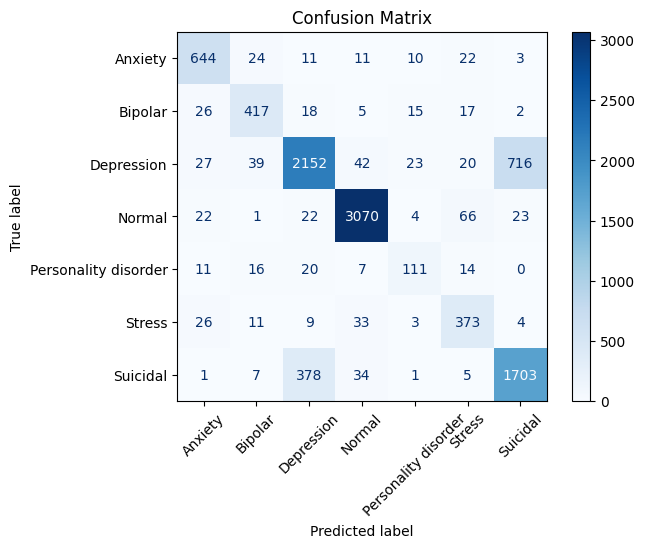

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


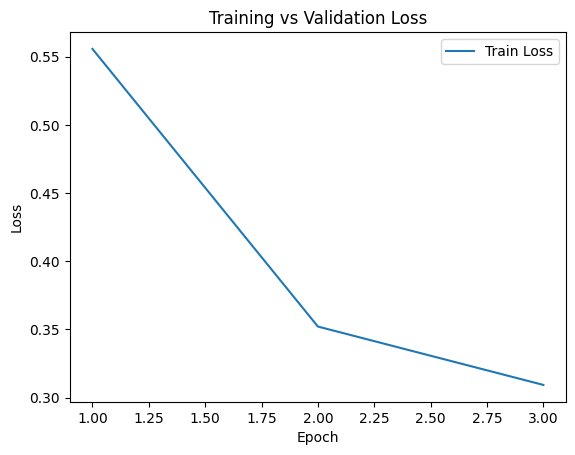

In [33]:
import matplotlib.pyplot as plt

epochs = range(1, len(log_callback.history["train_loss"]) + 1)

# Train Loss curve
if log_callback.history["train_loss"]:
    plt.plot(epochs, log_callback.history["train_loss"], label="Train Loss")

# Eval Loss curve (only if available)
if log_callback.history["eval_loss"]:
    plt.plot(epochs, log_callback.history["eval_loss"], label="Eval Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Accuracy curve (if available)
if log_callback.history["eval_accuracy"]:
    plt.plot(epochs, log_callback.history["eval_accuracy"], marker="o", label="Eval Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")
    plt.show()


In [42]:
# Function to predict user input text
def predict_manual():
    text = input("Enter a sentence: ")
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    print(f"Predicted Category: {id2label[pred]}")

# Run it
predict_manual()


Enter a sentence: i am killer
Predicted Category: Suicidal
